In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [697]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

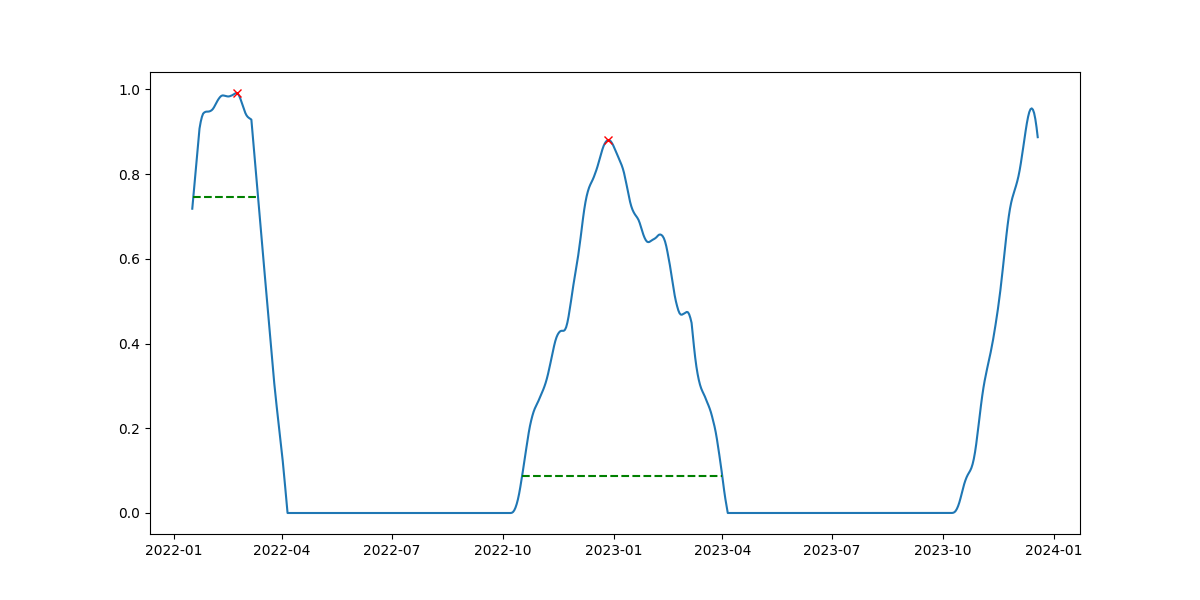

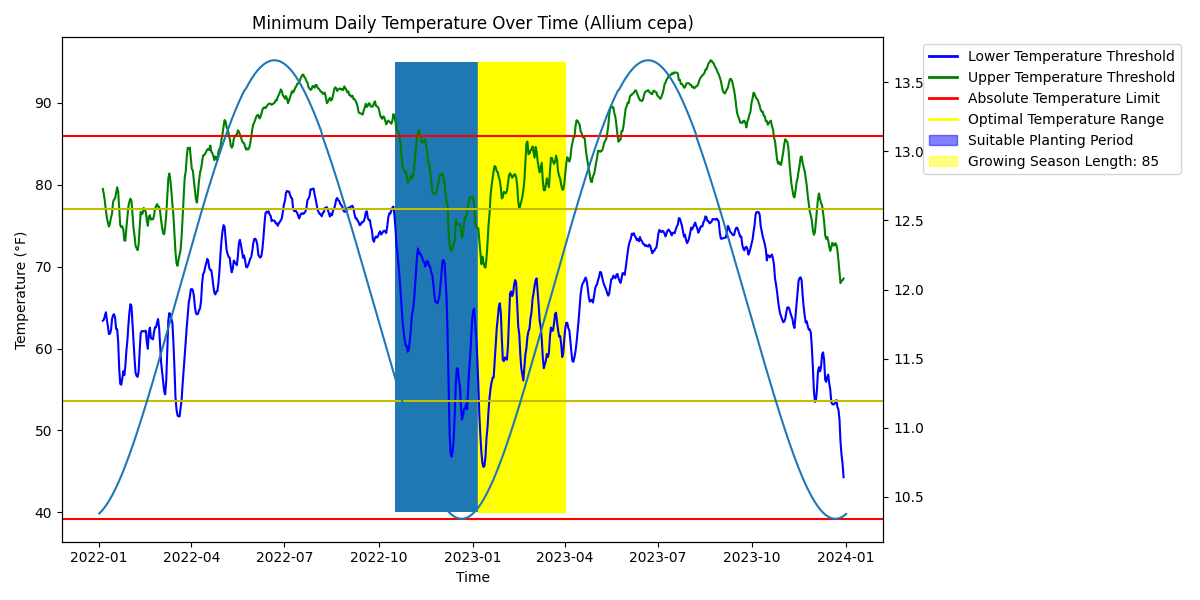

{85: [(10, 17, 1, 5)],
 95: [(10, 17, 12, 26)],
 105: [(10, 17, 12, 16)],
 115: [(10, 17, 12, 6)],
 125: [(10, 17, 11, 26)],
 135: [(10, 17, 11, 16)],
 145: [(10, 17, 11, 6)],
 155: [(10, 17, 10, 27)],
 165: [],
 175: []}

In [698]:
%matplotlib widget

# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
bolting = False
frost_tolerance = 0


# short day: 11-12, long=14;16
min_day = 10
max_day = 12
crop_sim.all_in_one("33483", crop_name, bolting, min_day, max_day)

In [645]:
# crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name, cutoff)

In [631]:
# suit = growing_season_suitability[view_window]
# x = suit.where(suit > 0)
# y = xr.where(suit > 0, suit, 0)
# x == y
# print(suit)

In [646]:
# plt.subplots(figsize=(12, 6))

# # plt.plot(suit.time, .isel(lat=lat,lon=lon), color="green")
# plt.plot(suit.time, suit.isel(lat=lat,lon=lon))
# # from scipy.signal import savgol_filter
# # # Apply Savitzky-Golay filter
# # window_length = 13  # Must be odd
# # polyorder = 3

# # smoothed_data = xr.apply_ufunc(
# #     savgol_filter,
# #     suit,
# #     kwargs={"window_length": window_length, "polyorder": polyorder},
# #     input_core_dims=[["time"]],
# #     output_core_dims=[["time"]],  # Output is a single value per input
# #     output_dtypes=[suit.dtype]
# # )
# # plt.plot(smoothed_data.isel(lat=lat,lon=lon))
# plt.show()